In [5]:
from integrators import contact as ic
from integrators.common import _rk4 as rk4
from lienard import integrator as li
from lienard import models as lm

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

# def step6b(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1b):
#     return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import progressbar

In [7]:
def err(x, y):
    return np.maximum.accumulate(np.abs(x-y))

In [8]:
def ivp_fhn(a,b,c, z=None):
    z = z if z is not None else (lambda _: 0.0)
    return lambda y, t: [
        c*(y[0] + y[1] - (1.0/3.0)*(y[0]**3) + z(t)),
        -1/c*(y[0] - a + b*y[1])
    ]

def ivp_w(a,b,c, z=None, dz=None):
    z = z if z is not None else (lambda _: 0.0)
    dz = dz if dz is not None else (lambda t: derivative(z, t, dx=1e-10))
    
    return lambda y, t: [
        y[1],
        a + y[0] * (b-1) -b * y[0]**3/3 + (c*(1-y[0]**2) - b/c)* y[1] + b*z(t) + c*dz(t)
    ]

## FitzHugh--Nagumo model without external current

In [9]:
tspan = np.arange(0, 500, 0.02)

a,b,c=0.7,0.8,3
x0,y0=-0.650,0

y_init, params = [x0, y0], (a,b,c)

frinag=lm.FitzHughNagumo(a,b,c, forcing=lambda _: 0, dforcing=lambda _: 0)
q0,p0,s0=x0,0,frinag.xytos(x0,y0)
y_w_init = [x0, s0]

In [10]:
sol, sols, _ = ic.integrate(li.step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

In [11]:
fix_ivp_fhn = ivp_fhn(a,b,c,z=lambda _: 0)
fix_ivp_w = ivp_w(a,b,c,z=lambda _: 0, dz=lambda _: 0)

y_odeint, info = si.odeint(fix_ivp_fhn, y_init, tspan, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

y_odeint_w, info = si.odeint(fix_ivp_w, y_w_init, tspan, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 1980, number of Jacobian evaluations: 9
Number of function evaluations: 2900, number of Jacobian evaluations: 39


In [13]:
derivs = lambda t, y: fix_ivp_fhn(y,t)
derivs_w = lambda t, y: fix_ivp_w(y,t)
srk = rk4(derivs, y_init, tspan)
srk_w = rk4(derivs_w, y_w_init, tspan)

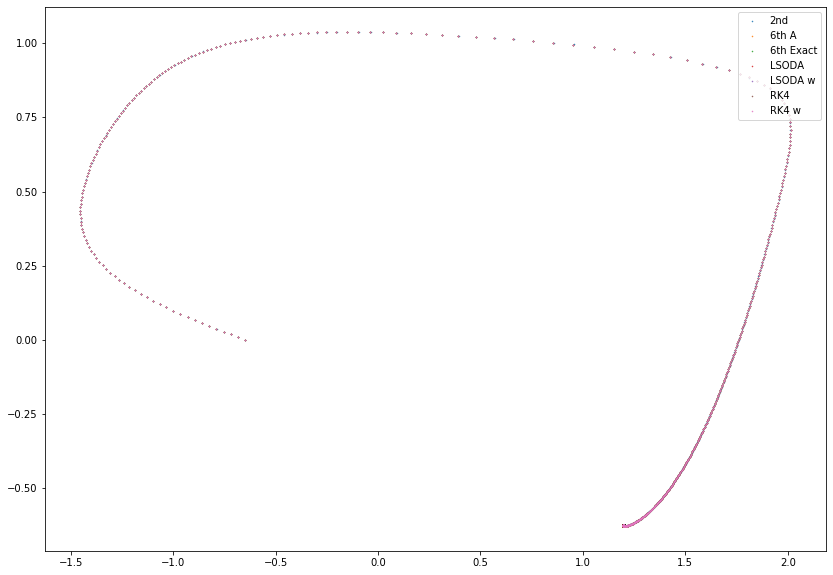

In [14]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(y_odeint_w[:, 0], frinag.qstoy(y_odeint_w[:, 0],y_odeint_w[:, 1]), '.',markersize=1,label="LSODA w")
plt.plot(srk[:,0], srk[:,1],'.',markersize=1,label="RK4")
plt.plot(srk_w[:,0], frinag.qstoy(srk_w[:,0],srk_w[:,1]),'.',markersize=1,label="RK4 w")
plt.legend(loc="upper right")
plt.show()

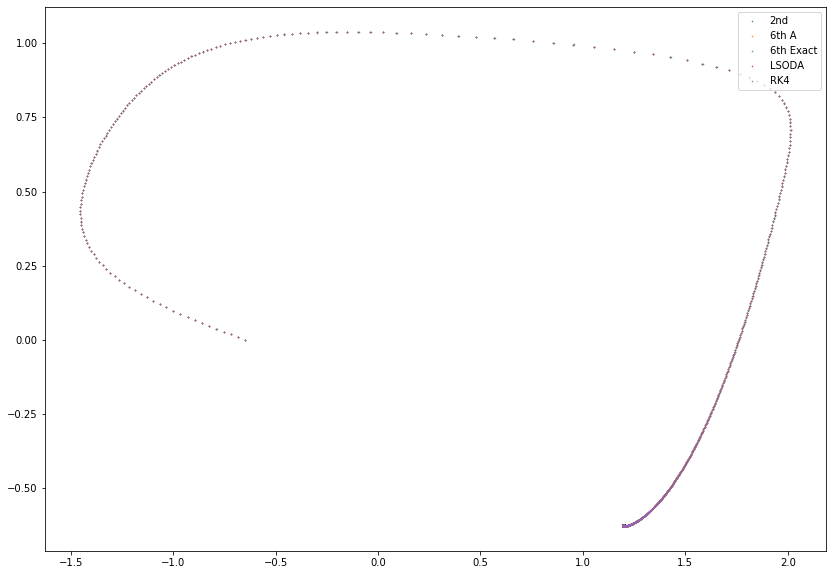

In [15]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(srk[:,0], srk[:,1],'.',markersize=1,label="RK4")

plt.legend(loc="upper right")
plt.show()

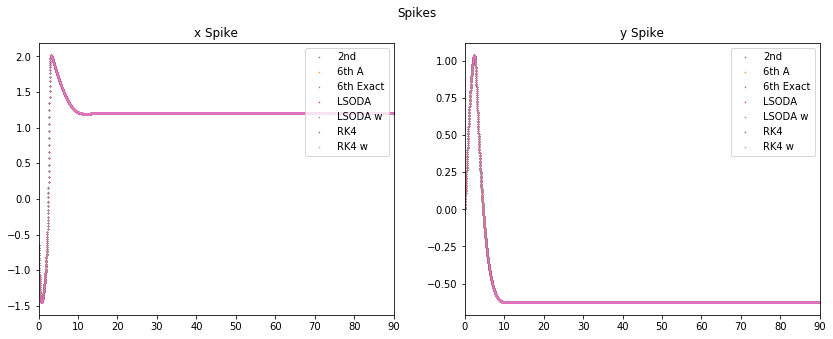

In [16]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.plot(tspan, y_odeint_w[:, 0], '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,0],'.',markersize=1,label="RK4")
plt.plot(tspan, srk_w[:,0],'.',markersize=1,label="RK4 w")
plt.xlim((0,90))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(tspan, frinag.qstoy(y_odeint_w[:, 0],y_odeint_w[:, 1]), '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,1],'.',markersize=1,label="RK4")
plt.plot(tspan, frinag.qstoy(srk_w[:,0],srk_w[:,1]),'.',markersize=1,label="RK4 w")
plt.xlim((0,90))
plt.legend(loc="upper right")

plt.show()

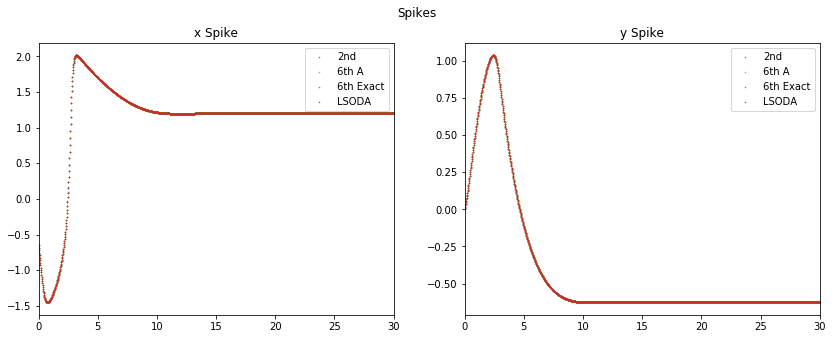

In [17]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.xlim((0,30))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.xlim((0,30))
plt.legend(loc="upper right")

plt.show()

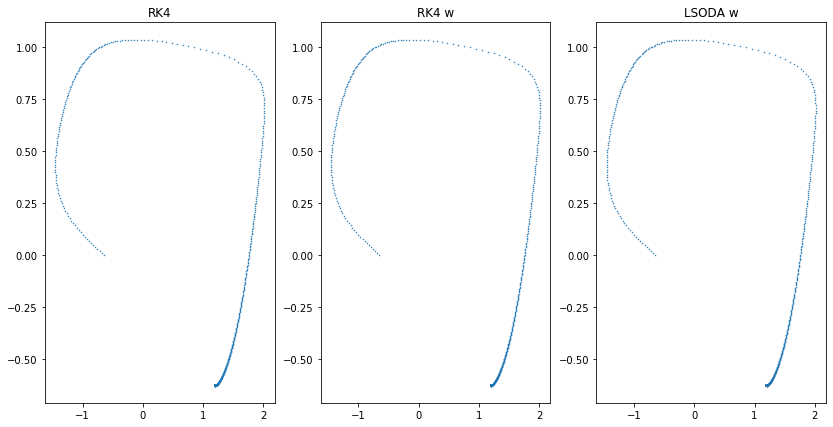

In [18]:
plt.figure(figsize=(14,7))
plt.subplot(131)
plt.gca().set_title("RK4")
plt.plot(srk[:,0], srk[:,1],'.',markersize=1)
plt.subplot(132)
plt.gca().set_title("RK4 w")
plt.plot(srk_w[:,0], frinag.qstoy(srk_w[:,0], srk_w[:,1]),'.',markersize=1)
plt.subplot(133)
plt.gca().set_title("LSODA w")
plt.plot(y_odeint_w[:,0], frinag.qstoy(y_odeint_w[:,0], y_odeint_w[:,1]),'.',markersize=1)
plt.show()

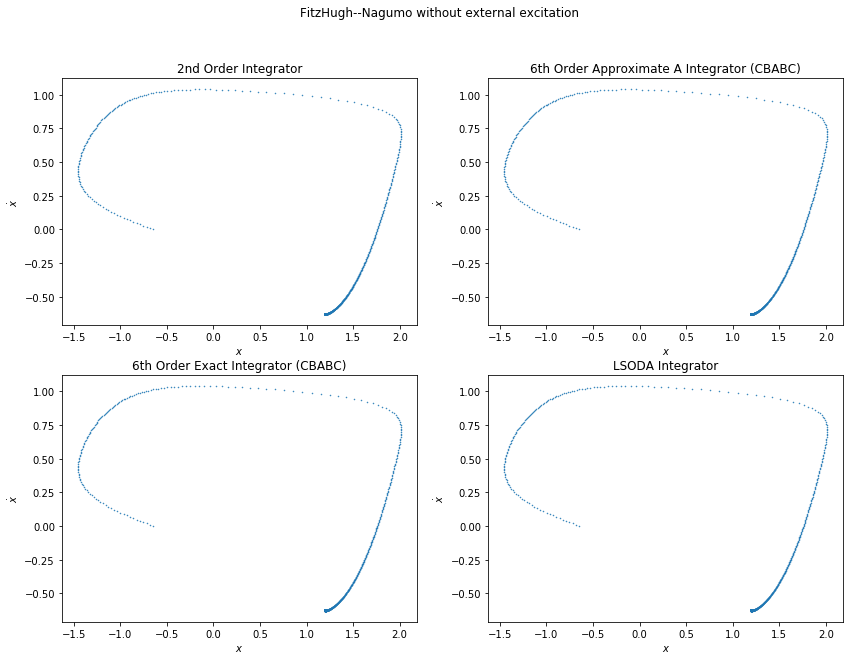

In [19]:
plt.figure(figsize=(14,10))

plt.suptitle("FitzHugh--Nagumo without external excitation")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order Approximate A Integrator (CBABC)")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order Exact Integrator (CBABC)")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

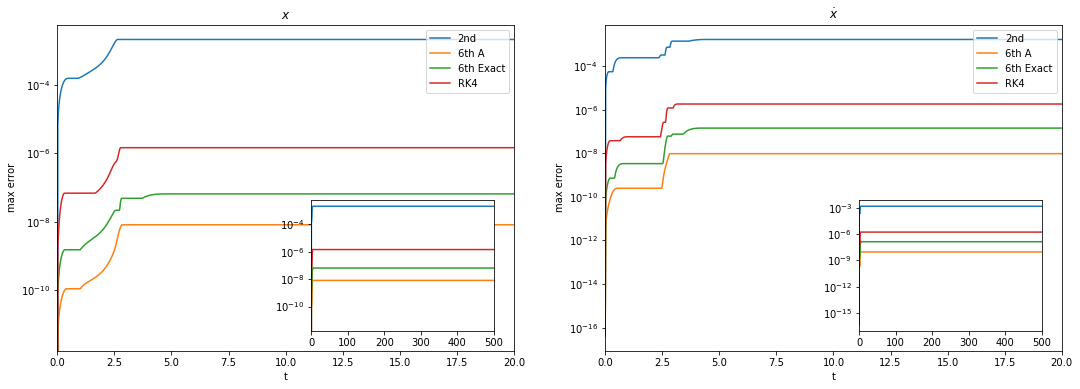

In [20]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.plot(tspan,
        err(srk_w[:,0],y_odeint[:,0]),label="RK4")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad=2)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.plot(tspan,
        err(srk_w[:,0],y_odeint[:,0]),label="RK4")
axins.set_yscale('log')
axins.set_xlim(0,500)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
ax.plot(tspan,
        err(frinag.qstoy(srk_w[:,0],srk_w[:,1]),y_odeint[:,1]),label="RK4")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad = 2)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.plot(tspan,
        err(frinag.qstoy(srk_w[:,0],srk_w[:,1]),y_odeint[:,1]),label="RK4")
axins.set_yscale('log')
axins.set_xlim(0,500)

plt.show()

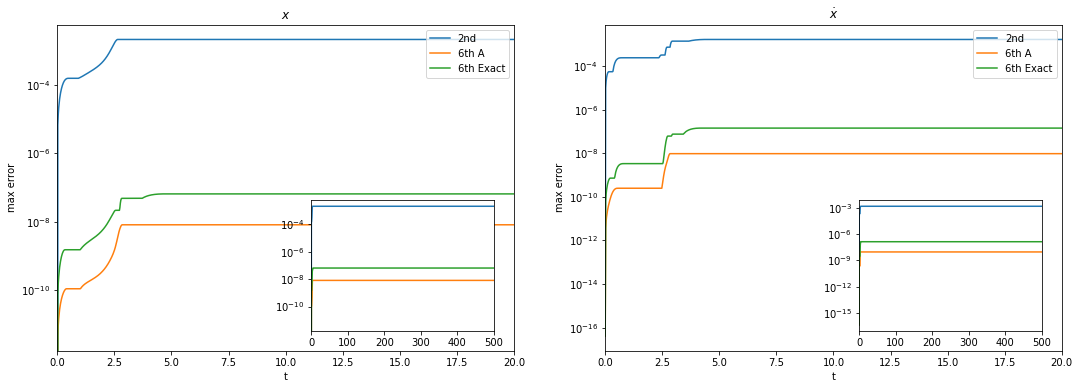

In [21]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad=2)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad = 2)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

plt.show()

## Fritzhugh-Nagumo with square pulse excitation

In [35]:
tspan = np.arange(0, 500, 0.02)

a,b,c, i0=0.7,0.8,3.0,-0.4
x0,y0=-0.650,0

def square_pulse(t):
    return i0*np.heaviside(t,0)-i0*np.heaviside(t-100,0)

def d_square_pulse(t):
    if abs(t) < 1e-10:
        return i0
    elif abs(t-100) < 1e-10:
        return i0
    else:
        return 0.0

In [36]:
y_init, params = [x0, y0], (a,b,c)

frinag=lm.FitzHughNagumo(a,b,c, forcing=square_pulse, dforcing=d_square_pulse)

q0,p0,s0=x0,0,frinag.xytos(x0,y0)
y_w_init = [x0, s0]

In [37]:
fix_ivp_fhn = ivp_fhn(a,b,c,z=square_pulse)
fix_ivp_w = ivp_w(a,b,c,z=square_pulse, dz=d_square_pulse)

y_odeint, info = si.odeint(fix_ivp_fhn, y_init, tspan, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

y_odeint_w, info = si.odeint(fix_ivp_w, y_w_init, tspan, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 15397, number of Jacobian evaluations: 10
Number of function evaluations: 94772, number of Jacobian evaluations: 2312


In [38]:
derivs = lambda t, y: fix_ivp_fhn(y,t)
derivs_w = lambda t, y: fix_ivp_w(y,t)
srk = rk4(derivs, y_init, tspan)
srk_w = rk4(derivs_w, y_w_init, tspan)

In [39]:
sol, sols, _ = ic.integrate(li.step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

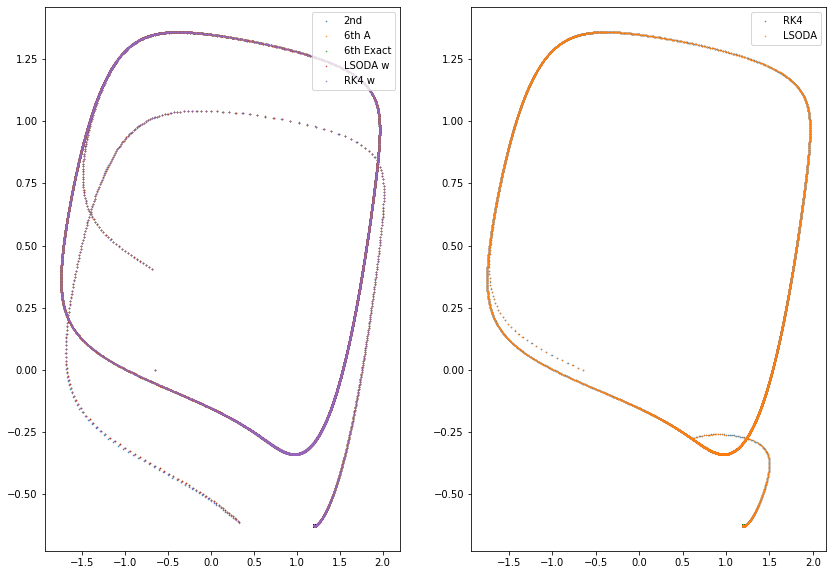

In [40]:
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols,tspan), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms,tspan),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s,tspan),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint_w[:, 0], frinag.qstoy(y_odeint_w[:, 0],y_odeint_w[:, 1],tspan), '.',markersize=1,label="LSODA w")
plt.plot(srk_w[:,0], frinag.qstoy(srk_w[:,0],srk_w[:,1],tspan),'.',markersize=1,label="RK4 w")
plt.legend(loc="upper right")

plt.subplot(122)
plt.plot(srk[:,0], srk[:,1],'.',markersize=1,label="RK4")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.legend(loc="upper right")
plt.show()

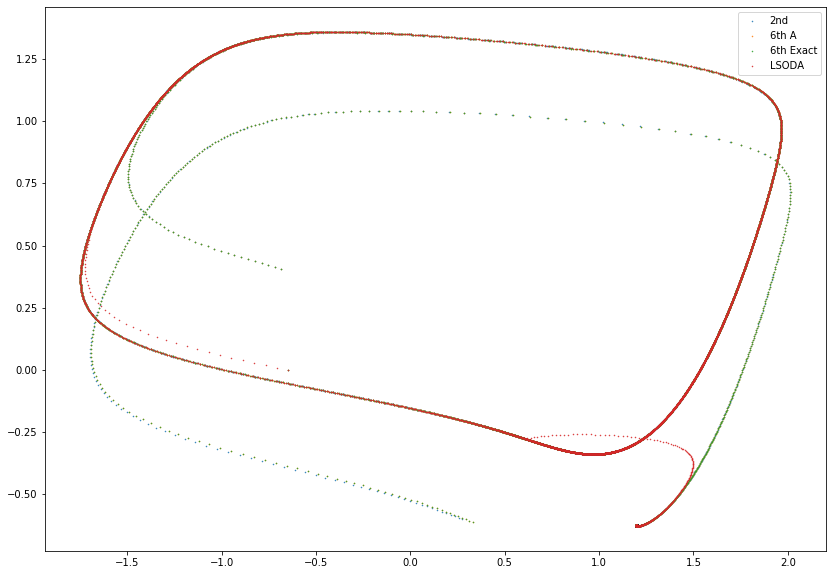

In [41]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], (frinag.qstoy(sol[:,1],sols,tspan)), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], (frinag.qstoy(solm[:,1],solms,tspan)),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], (frinag.qstoy(sol1[:,1],sol1s,tspan)),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.legend(loc="upper right")
plt.show()

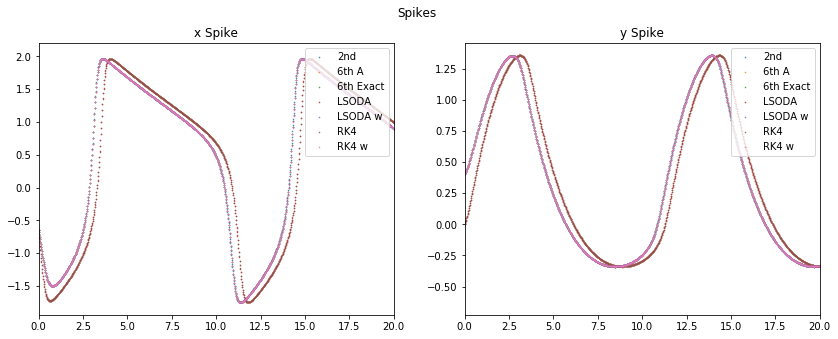

In [42]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.plot(tspan, y_odeint_w[:, 0], '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,0],'.',markersize=1,label="RK4")
plt.plot(tspan, srk_w[:,0],'.',markersize=1,label="RK4 w")
plt.xlim((0,20))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols,tspan), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms,tspan),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s,tspan),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(tspan, frinag.qstoy(y_odeint_w[:, 0],y_odeint_w[:, 1],tspan), '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,1],'.',markersize=1,label="RK4")
plt.plot(tspan, frinag.qstoy(srk_w[:,0],srk_w[:,1],tspan),'.',markersize=1,label="RK4 w")
plt.xlim((0,20))
plt.legend(loc="upper right")

plt.show()

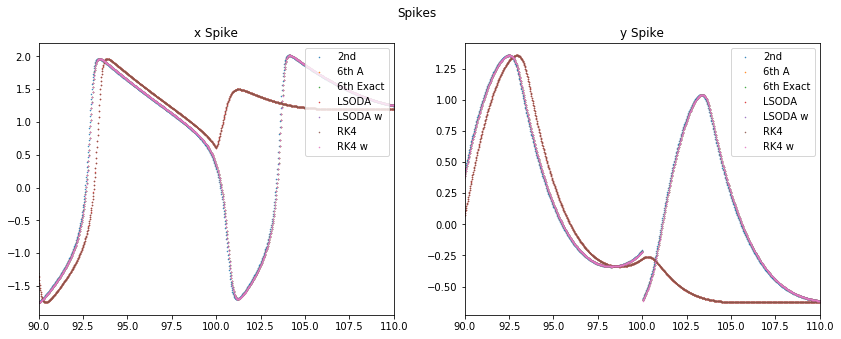

In [43]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.plot(tspan, y_odeint_w[:, 0], '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,0],'.',markersize=1,label="RK4")
plt.plot(tspan, srk_w[:,0],'.',markersize=1,label="RK4 w")
plt.xlim((90,110))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols,tspan), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms,tspan),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s,tspan),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(tspan, frinag.qstoy(y_odeint_w[:, 0],y_odeint_w[:, 1],tspan), '.',markersize=1,label="LSODA w")
plt.plot(tspan, srk[:,1],'.',markersize=1,label="RK4")
plt.plot(tspan, frinag.qstoy(srk_w[:,0],srk_w[:,1],tspan),'.',markersize=1,label="RK4 w")
plt.xlim((90,110))
plt.legend(loc="upper right")

plt.show()

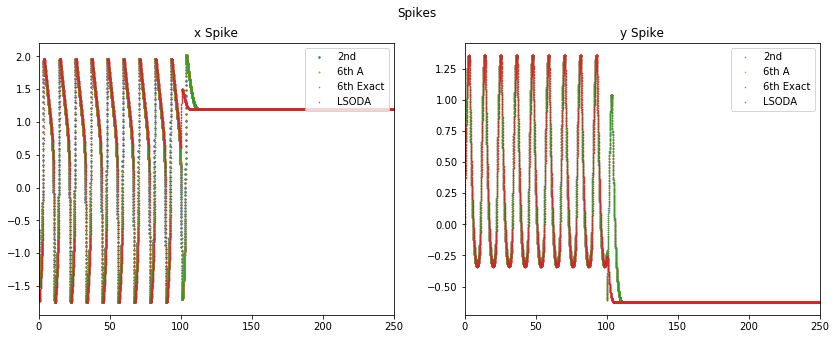

In [44]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=3,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=2,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols,tspan), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms,tspan),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s,tspan),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.show()

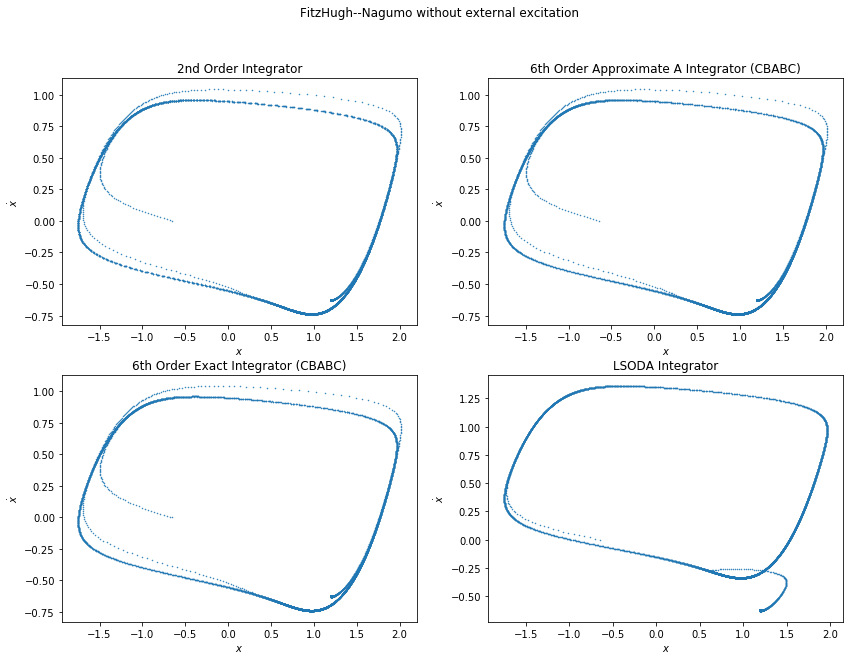

In [45]:
plt.figure(figsize=(14,10))

plt.suptitle("FitzHugh--Nagumo without external excitation")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order Approximate A Integrator (CBABC)")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order Exact Integrator (CBABC)")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

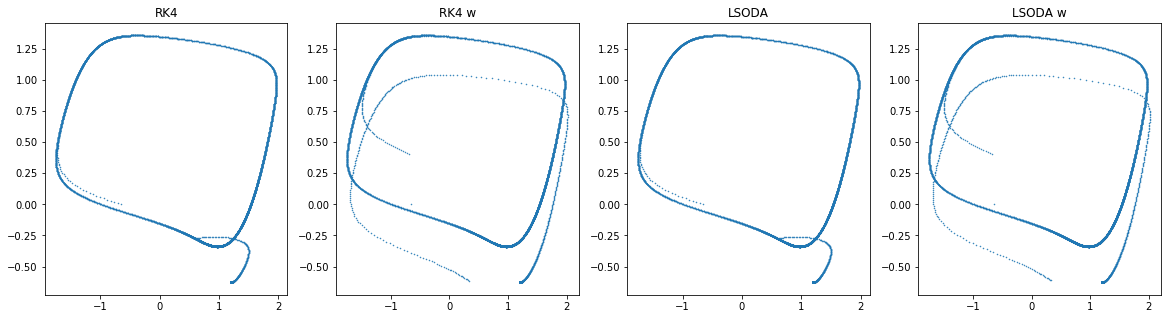

In [46]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.gca().set_title("RK4")
plt.plot(srk[:,0], srk[:,1],'.',markersize=1)
plt.subplot(142)
plt.gca().set_title("RK4 w")
plt.plot(srk_w[:,0], frinag.qstoy(srk_w[:,0], srk_w[:,1], tspan),'.',markersize=1)
plt.subplot(143)
plt.gca().set_title("LSODA")
plt.plot(y_odeint[:,0], y_odeint[:,1],'.',markersize=1)
plt.subplot(144)
plt.gca().set_title("LSODA w")
plt.plot(y_odeint_w[:,0], frinag.qstoy(y_odeint_w[:,0], y_odeint_w[:,1], tspan),'.',markersize=1)
plt.show()

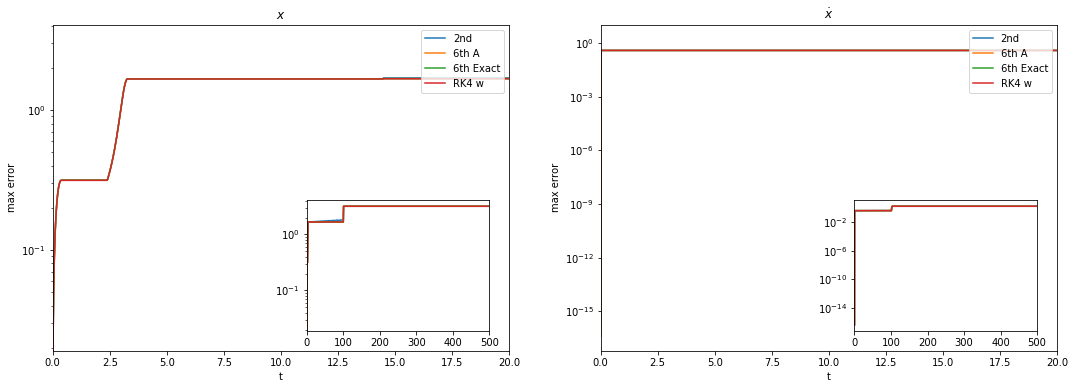

In [48]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.plot(tspan,
        err(srk_w[:,0],y_odeint[:,0]),label="RK4 w")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad=2)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.plot(tspan,
        err(srk_w[:,0],y_odeint[:,0]),label="RK4 w")
axins.set_yscale('log')
axins.set_xlim(0,500)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols,tspan),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms,tspan),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s,tspan),y_odeint[:,1]),label="6th Exact")
ax.plot(tspan,
        err(frinag.qstoy(srk_w[:,0],srk_w[:,1],tspan),y_odeint[:,1]),label="RK4 w")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad = 2)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols,tspan),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms,tspan),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s,tspan),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.plot(tspan,
        err(frinag.qstoy(srk_w[:,0],srk_w[:,1],tspan),y_odeint[:,1]),label="RK4 w")
axins.set_yscale('log')
axins.set_xlim(0,500)

plt.show()

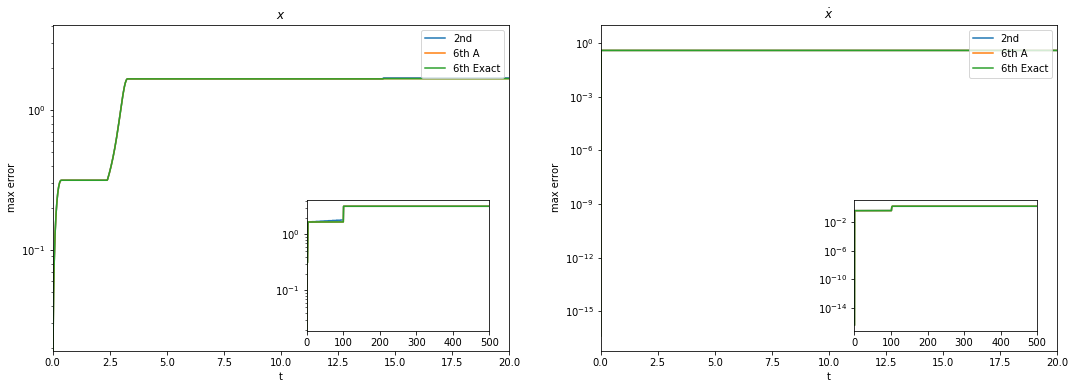

In [50]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad=2)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols,tspan),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms,tspan),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s,tspan),y_odeint[:,1]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad = 2)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols,tspan),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms,tspan),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s,tspan),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

plt.show()